In [1]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [2]:
import torch
import pickle
from dataloaders import get_data_loaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import numpy as np
import matplotlib.colors as colors
from sklearn.cluster import KMeans, OPTICS
from scipy.stats import iqr
from numpy.linalg import inv
import gc

In [3]:
# α=0.3
config_file_path = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/config.pkl'
#config_file_path = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)
config['data']['rescale_by_percentile'] = -1

In [4]:
dconfig = config['data']
train_data, val_data, test_data = get_data_loaders(**dconfig)

val_data = torch.utils.data.DataLoader(
    val_data.dataset, 
    batch_size=val_data.batch_size, 
    shuffle=True, 
    num_workers=val_data.num_workers, 
    collate_fn=val_data.collate_fn, 
    pin_memory=val_data.pin_memory, 
    drop_last=val_data.drop_last,
    timeout=val_data.timeout,
    worker_init_fn=val_data.worker_init_fn
)


In [5]:
DEVICE = 'cuda:0'
# α=0.3
checkpoint_file = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/checkpoints/model_checkpoint_016.pth.tar'
#checkpoint_file = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/checkpoints/model_checkpoint_011.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention(
  (_layers): ModuleList(
    (0): Bipartite_Layers(
      (enc): ModuleList(
        (0): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=37, out_features=128, bias=True)
            (fc_k): Linear(in_features=37, out_features=128, bias=True)
            (fc_v): Linear(in_features=37, out_features=128, bias=True)
            (fc_o): Linear(in_features=128, out_features=128, bias=True)
            (ln0): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
            (ln1): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
          )
        )
        (1): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=128, out_features=128, bias=True)
            (fc_k): Linear(in_features=128, out_features=128, bias=True)
            (fc_v): Linear(in_features=128, out_features=128, bias=True)
            (f

In [6]:
N_BATCHES = 100

def evaluate_model(val_data, dconfig, model, max_std, samples):
    correct = defaultdict(int)
    count = defaultdict(int)
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1

        mask = mask.to(DEVICE)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)
        track_vector = batch.track_vector.to(DEVICE)
        zeros = torch.zeros(track_vector.shape[0], track_vector.shape[1], 5, 3).to(DEVICE)
        for p in np.linspace(0, max_std, 10):
            print('*', end='')
            with torch.no_grad():
                e_v = torch.normal(zeros, p + zeros)
                Xp, _ = model.recalculate_geometric_features(track_vector, e_v, **dconfig)
                preds = model(Xp, mask)
                labels = torch.argmax(preds, dim=-1)
                correct[p] += torch.sum(labels == trigger.squeeze(-1)).detach().cpu().item()
                count[p] += labels.shape[0]
                del preds
                gc.collect()
        print()
    return correct, count

In [7]:
correct_contrastive, count_contrastive = evaluate_model(val_data, config['data'], model, max_std=5e-3, samples=50)
x_c = sorted(correct_contrastive.keys())
y_c = [correct_contrastive[i]/count_contrastive[i] for i in x_c]

  0%|          | 0/100 [00:00<?, ?it/s]

**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********

In [8]:
config_file_path = 'train_results/biatt-augment-adj/experiment_2023-06-10_10:53:17/config.pkl'
#config_file_path = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)
config['data']['rescale_by_percentile'] = -1
DEVICE = 'cuda:1'
# α=0.3
checkpoint_file = 'train_results/biatt-augment-adj/experiment_2023-06-10_10:53:17/checkpoints/model_checkpoint_016.pth.tar'
#checkpoint_file = 'train_results/biatt-glri/experiment_2023-02-12_08:24:52/checkpoints/model_checkpoint_011.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

correct_noncontrastive, count_noncontrastive = evaluate_model(val_data, config['data'], model, max_std=5e-3, samples=50)
x_nc = sorted(correct_noncontrastive.keys())
y_nc = [correct_noncontrastive[i]/count_noncontrastive[i] for i in x_nc]

  0%|          | 0/100 [00:00<?, ?it/s]

**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********
**********

Text(0.5, 1.0, 'Accuracy vs Perturbation')

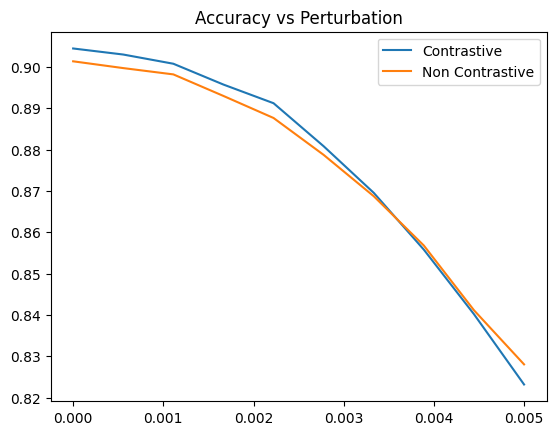

In [9]:
plt.plot(x_c, y_c, label='Contrastive')
plt.plot(x_nc, y_nc, label='Non Contrastive')
plt.legend()
plt.title("Accuracy vs Perturbation")